In [72]:
#imports 

In [73]:
# load and check DeepSTARR test set

from evoaug_utils import utils

data_path = '/grid/wsbs/home_norepl/pmantill/train_EvoAug/deepstarr-data.h5'

batch_size = 128
base_dataset = utils.H5Dataset(data_path, batch_size=batch_size, lower_case=False, transpose=False)

print("\nTest Set Dimensions:")
print(f"x_test shape: {base_dataset.x_test.shape}")
print(f"y_test shape: {base_dataset.y_test.shape}")


Test Set Dimensions:
x_test shape: torch.Size([41186, 4, 249])
y_test shape: torch.Size([41186, 2])


In [100]:
# Get GPU - been connecting via ssh to my gpu node
import torch
print(f'GPU detected: {torch.cuda.is_available()}')

GPU detected: True


In [75]:
# Load EvoAug DeepSTARR student model
# Use pylightning student architecture from distill_EvoAug2.py

import os
import torch
import numpy as np
from scipy import stats
from distill_EvoAug2 import UncertaintyAwareStudent, UncertaintyAwareLightningModel
from evoaug_utils.model_zoo import DeepSTARR 

# Paths
output_dir = '/grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_Library_Selection'
# New folder for saving outputs
selection_dir = '/grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_Library_Selection'
os.makedirs(selection_dir, exist_ok=True)
student_ckpt = os.path.join(output_dir, 'uncertainty_student.ckpt')

# Build a minimal "teacher" with just the DeepSTARR architecture (no weights)
teacher_model = type("Teacher", (), {"model": DeepSTARR(2)})()

# Build student and load trained weights
student_model = UncertaintyAwareStudent(teacher_model, num_tasks=2)
lightning_student = UncertaintyAwareLightningModel.load_from_checkpoint(student_ckpt, student_model=student_model)

# Device + eval
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lightning_student.to(device).eval()

print("Student model loaded successfully")

Student model loaded successfully


In [76]:
# Full-test predictions (mean head) and metrics.
# Save predictions and actual labels

with torch.no_grad():
    y_preds = []
    y_trues = []
    for x, y in base_dataset.test_dataloader():
        x = x.to(device).float()
        out = lightning_student(x)
        y_preds.append(out['mean'].cpu())
        y_trues.append(y)
    y_pred = torch.cat(y_preds, dim=0).numpy()
    y_true = torch.cat(y_trues, dim=0).numpy()

# MSE per task
mse_dev = np.mean((y_pred[:, 0] - y_true[:, 0])**2)
mse_hk  = np.mean((y_pred[:, 1] - y_true[:, 1])**2)

# Pearson r per task
r_dev = stats.pearsonr(y_pred[:, 0], y_true[:, 0])[0]
r_hk  = stats.pearsonr(y_pred[:, 1], y_true[:, 1])[0]

# Spearman rho per task
rho_dev = stats.spearmanr(y_pred[:, 0], y_true[:, 0])[0]
rho_hk  = stats.spearmanr(y_pred[:, 1], y_true[:, 1])[0]

print("Student model metrics:")
print(f"Dev - MSE: {mse_dev:.4f}, Pearson r: {r_dev:.4f}, Spearman rho: {rho_dev:.4f}")
print(f"HK  - MSE: {mse_hk:.4f}, Pearson r: {r_hk:.4f}, Spearman rho: {rho_hk:.4f}")

print("Student predictions generated")

# Build full test-set DataFrames for plotting
import pandas as pd
num_samples = y_true.shape[0]
import numpy as np
indices = np.arange(num_samples)

dev_df = pd.DataFrame({
    'index': indices,
    'actual_dev': y_true[:, 0],
    'pred_dev': y_pred[:, 0]
})

hk_df = pd.DataFrame({
    'index': indices,
    'actual_hk': y_true[:, 1],
    'pred_hk': y_pred[:, 1]
})

Student model metrics:
Dev - MSE: 1.1924, Pearson r: 0.7013, Spearman rho: 0.6703
HK  - MSE: 1.1400, Pearson r: 0.7795, Spearman rho: 0.5967
Student predictions generated


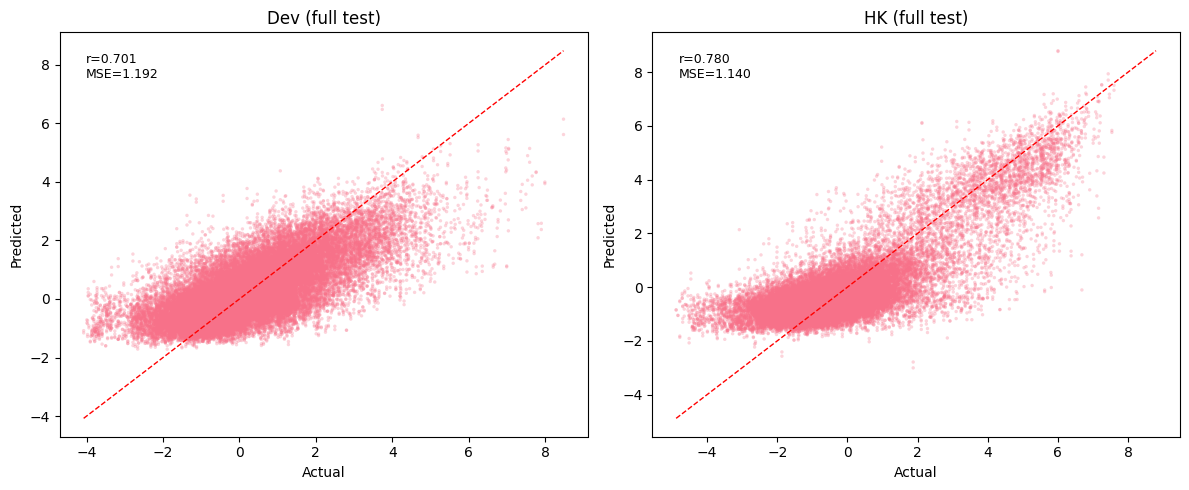

In [77]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def scatter_pred_vs_actual(ax, df, actual_col, pred_col, title):
    x = df[actual_col].values
    y = df[pred_col].values
    ax.scatter(x, y, s=6, alpha=0.3, edgecolor='none')
    vmin = float(min(x.min(), y.min()))
    vmax = float(max(x.max(), y.max()))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    # Metrics annotation
    mse = np.mean((y - x) ** 2)
    r = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f"r={r:.3f}\nMSE={mse:.3f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0))

scatter_pred_vs_actual(axes[0], dev_df, 'actual_dev', 'pred_dev', 'Dev (full test)')
scatter_pred_vs_actual(axes[1], hk_df, 'actual_hk', 'pred_hk', 'HK (full test)')

plt.tight_layout()
plot_path = os.path.join(selection_dir, 'pred_vs_actual_all.svg')
#plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()
#print(f"Saved: {plot_path}")

High-activity sequences saved (actual > 2.0):
 Dev: 12.97% (N=5340)
 HK : 9.23% (N=3802)
 MSE_dev (filtered): 2.8172, Pearson r: 0.4278, Spearman rho: 0.3932
 MSE_hk  (filtered): 3.1217, Pearson r: 0.6578, Spearman rho: 0.6656


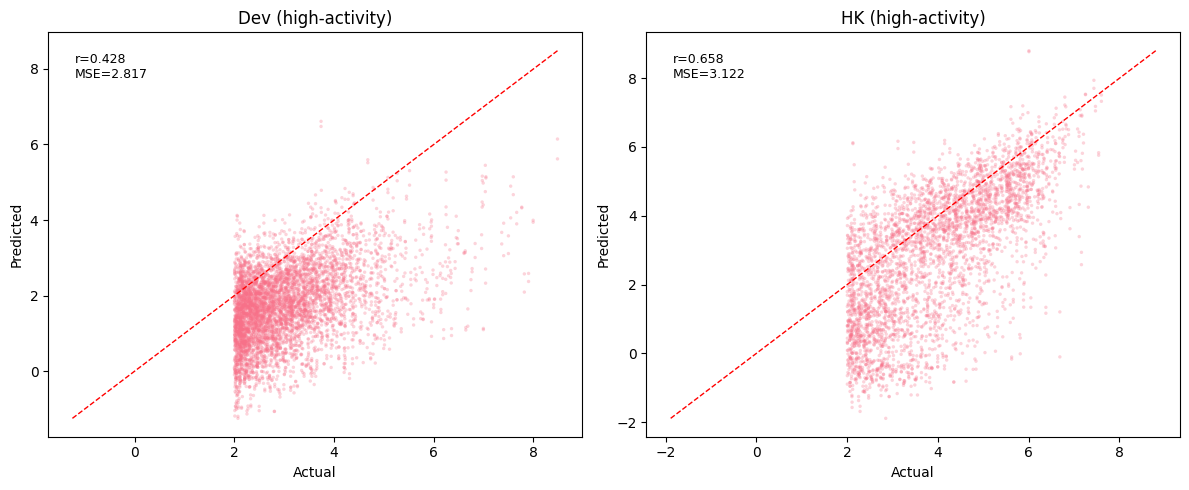

In [78]:
# Get high-activity test sequences per task with decoded sequence strings
# High activity defined as (actual > 2.0) AND (predicted > 2.0)

import os
import numpy as np
import pandas as pd
from scipy import stats
from tangermeme.utils import characters  # Convert one-hot to string
import torch

threshold = 2.0

# Ensure y_pred and y_true exist from previous cell
assert 'y_pred' in globals() and 'y_true' in globals(), "Run the metrics cell first to compute y_pred/y_true."

# Helper: decode one-hot sequence [4, L] -> string using tangermeme
@torch.no_grad()
def decode_sequences(indices):
    seq_list = []
    for i in indices:
        # base_dataset.x_test: [N, 4, L] torch tensor
        onehot = base_dataset.x_test[i]              # [4, L]
        onehot_L4 = onehot.permute(1, 0).contiguous()  # [L, 4]
        seq_list.append(characters(onehot_L4))
    return seq_list

# Dev (task 0): filter by actual only (> threshold)
mask_dev = (y_true[:, 0] > threshold)
idx_dev = np.where(mask_dev)[0]
seq_dev = [characters(base_dataset.x_test[i]) for i in idx_dev]

a_dev = y_true[idx_dev, 0]
p_dev = y_pred[idx_dev, 0]
high_dev_df = pd.DataFrame({
    'sequence': seq_dev,
    'actual_dev': a_dev,
    'pred_dev': p_dev
}).sort_values('actual_dev', ascending=False).reset_index(drop=True)

# HK (task 1): filter by actual only (> threshold)
mask_hk = (y_true[:, 1] > threshold)
idx_hk = np.where(mask_hk)[0]
seq_hk = [characters(base_dataset.x_test[i]) for i in idx_hk]

a_hk = y_true[idx_hk, 1]
p_hk = y_pred[idx_hk, 1]
high_hk_df = pd.DataFrame({
    'sequence': seq_hk,
    'actual_hk': a_hk,
    'pred_hk': p_hk
}).sort_values('actual_hk', ascending=False).reset_index(drop=True)

# Add SE columns for simple filtering later
high_dev_df['se_dev'] = (high_dev_df['pred_dev'] - high_dev_df['actual_dev'])**2
high_hk_df['se_hk'] = (high_hk_df['pred_hk'] - high_hk_df['actual_hk'])**2

# Save to CSV in selection_dir
high_dev_path = os.path.join(selection_dir, 'high_activity_dev.csv')
high_hk_path = os.path.join(selection_dir, 'high_activity_hk.csv')
high_dev_df.to_csv(high_dev_path, index=False)
high_hk_df.to_csv(high_hk_path, index=False)

# Recompute metrics on filtered subsets only
pred_dev_f = high_dev_df['pred_dev'].values
true_dev_f = high_dev_df['actual_dev'].values
pred_hk_f  = high_hk_df['pred_hk'].values
true_hk_f  = high_hk_df['actual_hk'].values

mse_dev_f = np.mean((pred_dev_f - true_dev_f)**2) if len(pred_dev_f) > 0 else np.nan
mse_hk_f  = np.mean((pred_hk_f  - true_hk_f )**2) if len(pred_hk_f) > 0 else np.nan
r_dev_f   = stats.pearsonr(true_dev_f, pred_dev_f)[0] if len(pred_dev_f) > 1 else np.nan
r_hk_f    = stats.pearsonr(true_hk_f,  pred_hk_f )[0] if len(pred_hk_f) > 1 else np.nan
rho_dev_f = stats.spearmanr(true_dev_f, pred_dev_f)[0] if len(pred_dev_f) > 1 else np.nan
rho_hk_f  = stats.spearmanr(true_hk_f,  pred_hk_f )[0] if len(pred_hk_f) > 1 else np.nan

pct_dev = 100.0 * len(high_dev_df) / len(base_dataset.x_test)
pct_hk  = 100.0 * len(high_hk_df) / len(base_dataset.x_test)

print("High-activity sequences saved (actual > 2.0):")
print(f" Dev: {pct_dev:.2f}% (N={len(high_dev_df)})")
print(f" HK : {pct_hk:.2f}% (N={len(high_hk_df)})")

print(f" MSE_dev (filtered): {mse_dev_f:.4f}, Pearson r: {r_dev_f:.4f}, Spearman rho: {rho_dev_f:.4f}")
print(f" MSE_hk  (filtered): {mse_hk_f:.4f}, Pearson r: {r_hk_f:.4f}, Spearman rho: {rho_hk_f:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def scatter_pred_vs_actual(ax, df, actual_col, pred_col, title):
    x = df[actual_col].values
    y = df[pred_col].values
    ax.scatter(x, y, s=6, alpha=0.3, edgecolor='none')
    vmin = float(min(x.min(), y.min()))
    vmax = float(max(x.max(), y.max()))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    # Metrics annotation
    mse = np.mean((y - x) ** 2)
    r = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f"r={r:.3f}\nMSE={mse:.3f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0))

scatter_pred_vs_actual(axes[0], high_dev_df, 'actual_dev', 'pred_dev', 'Dev (high-activity)')
scatter_pred_vs_actual(axes[1], high_hk_df, 'actual_hk', 'pred_hk', 'HK (high-activity)')

plt.tight_layout()
plot_path = os.path.join(selection_dir, 'pred_vs_actual_high_activity.svg')
#plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()
#print(f"Saved: {plot_path}")

Recommended Student Squared Error Cutoff (of high-activity sequences):
Dev: 75% ~ 4005/5340 sequences ~ SE <= 3.781
HK: 79% ~ 3003/3802 sequences ~ SE <= 4.882
Data has been filtered to apply the recommended SE cutoffs. These percentages are based on the high-activity sequences.


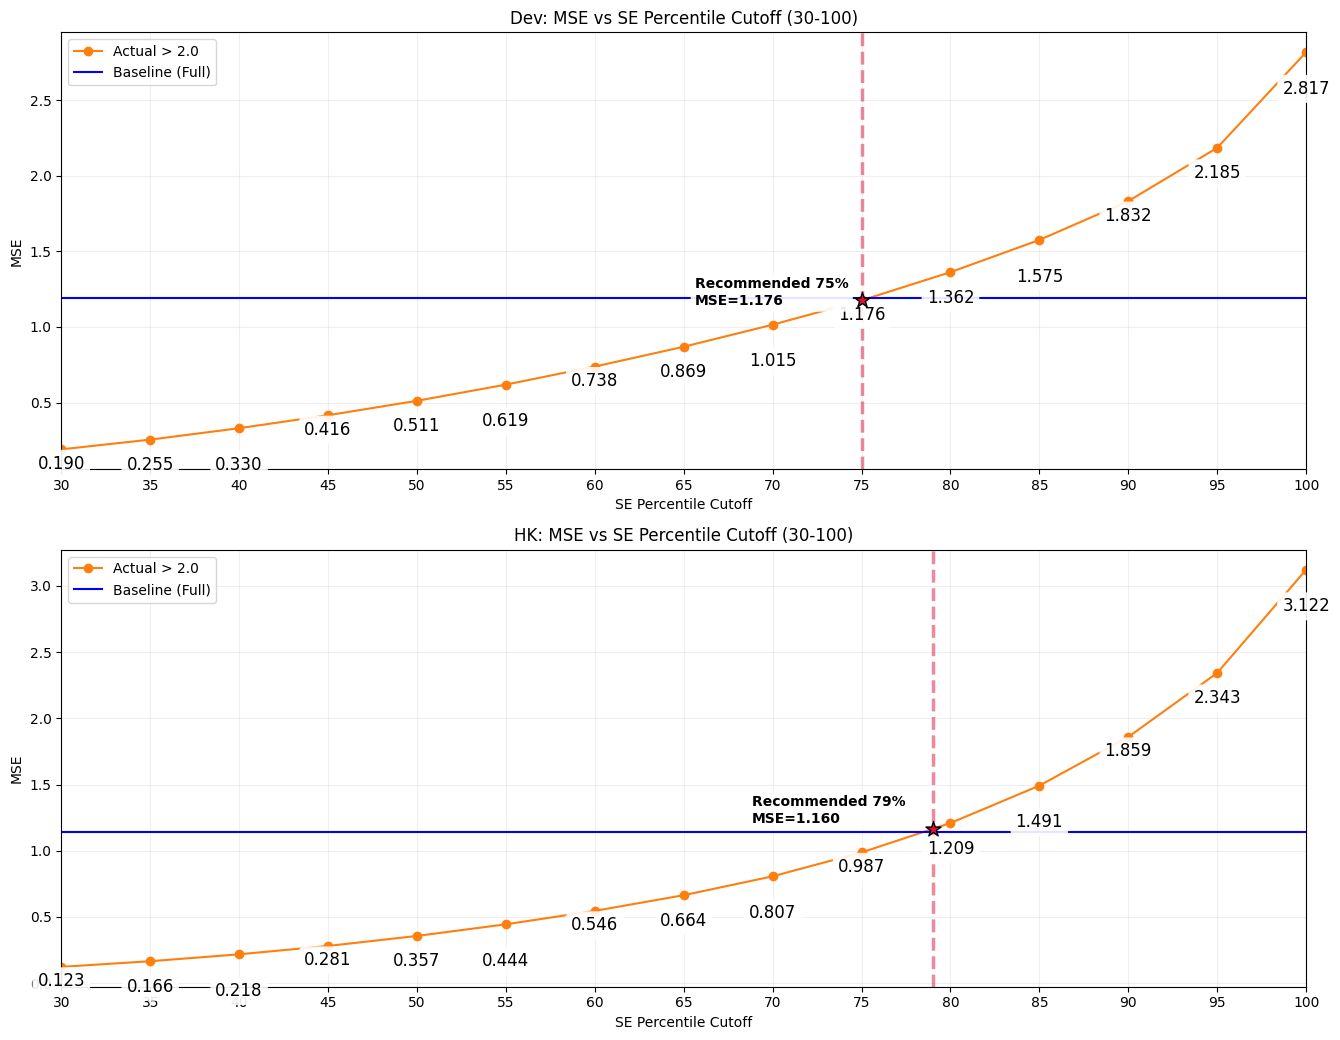

In [105]:
# MSE-only performance vs SE percentile cutoff (30-100%) with clearer labels
# - Larger figure and staggered labels for readability
# - Recommended cutoff per task based on MSE only, searched at 1% resolution
percentiles_plot = np.arange(30, 101, 5)
percentiles_fine = np.arange(30, 101, 1)

se_dev = (y_pred[:, 0] - y_true[:, 0])**2
se_hk  = (y_pred[:, 1] - y_true[:, 1])**2

# Masks for actual > 2.0
mask_actual_dev = y_true[:, 0] > 2.0
mask_actual_hk  = y_true[:, 1] > 2.0

# Helper to compute MSE curve given a list of percentiles

def compute_mse_curve_for_ps(y_true_col, y_pred_col, se_task, ps, mask_condition=None):
    mse_vals = []
    for p in ps:
        if mask_condition is not None:
            se_subset = se_task[mask_condition]
            cut = np.percentile(se_subset, p) if se_subset.size > 0 else np.nan
            if np.isfinite(cut):
                mask = (se_task <= cut) & mask_condition
            else:
                mask = np.zeros_like(se_task, dtype=bool)
        else:
            cut = np.percentile(se_task, p)
            mask = se_task <= cut
        x = y_true_col[mask]
        y = y_pred_col[mask]
        mse_vals.append(float(np.mean((y - x)**2)) if x.size >= 1 else np.nan)
    return np.array(mse_vals)

# Baselines
baseline_mse_dev_full = float(np.mean((y_pred[:, 0] - y_true[:, 0])**2))
baseline_mse_hk_full  = float(np.mean((y_pred[:, 1] - y_true[:, 1])**2))

# Curves for plotting (every 5%)
mse_dev_full_plot = compute_mse_curve_for_ps(y_true[:, 0], y_pred[:, 0], se_dev, percentiles_plot)
mse_dev_act_plot  = compute_mse_curve_for_ps(y_true[:, 0], y_pred[:, 0], se_dev, percentiles_plot, mask_actual_dev)

mse_hk_full_plot = compute_mse_curve_for_ps(y_true[:, 1], y_pred[:, 1], se_hk, percentiles_plot)
mse_hk_act_plot  = compute_mse_curve_for_ps(y_true[:, 1], y_pred[:, 1], se_hk, percentiles_plot, mask_actual_hk)

# Curves for recommendation search (every 1%)
mse_dev_act_fine = compute_mse_curve_for_ps(y_true[:, 0], y_pred[:, 0], se_dev, percentiles_fine, mask_actual_dev)
mse_hk_act_fine  = compute_mse_curve_for_ps(y_true[:, 1], y_pred[:, 1], se_hk, percentiles_fine, mask_actual_hk)

# Recommended cutoffs per task based on MSE only (closest to Full baseline)
idx_dev_mse = int(np.nanargmin(np.abs(mse_dev_act_fine - baseline_mse_dev_full))) if np.isfinite(mse_dev_act_fine).any() else None
p_rec_dev_mse = int(percentiles_fine[idx_dev_mse]) if idx_dev_mse is not None else np.nan
mse_rec_dev = float(mse_dev_act_fine[idx_dev_mse]) if idx_dev_mse is not None else np.nan

idx_hk_mse = int(np.nanargmin(np.abs(mse_hk_act_fine - baseline_mse_hk_full))) if np.isfinite(mse_hk_act_fine).any() else None
p_rec_hk_mse = int(percentiles_fine[idx_hk_mse]) if idx_hk_mse is not None else np.nan
mse_rec_hk = float(mse_hk_act_fine[idx_hk_mse]) if idx_hk_mse is not None else np.nan

# Compute SE cutoffs corresponding to recommended percentiles (within high-activity subsets)
se_cut_dev = np.percentile(se_dev[mask_actual_dev], p_rec_dev_mse) if np.isfinite(p_rec_dev_mse) and mask_actual_dev.any() else np.nan
se_cut_hk  = np.percentile(se_hk[mask_actual_hk],  p_rec_hk_mse)  if np.isfinite(p_rec_hk_mse) and mask_actual_hk.any() else np.nan

# Plot
fig, axs = plt.subplots(2, 1, figsize=(13.5, 10.5))
color_full = '#1f77b4'
color_act  = '#ff7f0e'
rec_color  = 'crimson'
label_bbox = dict(boxstyle='round', facecolor='white', alpha=0.9, linewidth=0)

# Dev MSE
#axs[0].plot(percentiles_plot, mse_dev_full_plot, color=color_full, marker='o', label='Full')
axs[0].plot(percentiles_plot, mse_dev_act_plot,  color=color_act,  marker='o', label='Actual > 2.0')
axs[0].axhline(baseline_mse_dev_full, color='blue', linestyle='-', label='Baseline (Full)')
# Staggered labels
##for i, (p, val) in enumerate(zip(percentiles_plot, mse_dev_full_plot)):
##    dy = 10 + (i % 3) * 8
##    axs[0].annotate(f"{val:.3f}", (p, val), textcoords='offset points', xytext=(0, dy), ha='center', fontsize=12, bbox=label_bbox)
for i, (p, val) in enumerate(zip(percentiles_plot, mse_dev_act_plot)):
    dy = -14 - (i % 3) * 8
    axs[0].annotate(f"{val:.3f}", (p, val), textcoords='offset points', xytext=(0, dy), ha='center', fontsize=12, bbox=label_bbox)
axs[0].set_title('Dev: MSE vs SE Percentile Cutoff (30-100)')
axs[0].set_xlabel('SE Percentile Cutoff')
axs[0].set_ylabel('MSE')
axs[0].set_xlim(30, 100)
axs[0].set_xticks(percentiles_plot)
axs[0].grid(alpha=0.2)
axs[0].legend()
# Recommended line/point
if np.isfinite(p_rec_dev_mse):
    axs[0].axvline(p_rec_dev_mse, color=rec_color, linestyle='--', linewidth=2.5, alpha=0.50, label='Recommended cutoff (MSE)')
    axs[0].scatter([p_rec_dev_mse], [mse_rec_dev], color=rec_color, edgecolor='k', s=130, marker='*', zorder=5)
    axs[0].annotate(f"Recommended {p_rec_dev_mse}%\nMSE={mse_rec_dev:.3f}", (p_rec_dev_mse, mse_rec_dev),
                    textcoords='offset points', xytext=(-120, -3), fontsize=10, fontweight='bold',
                    bbox=label_bbox)

# HK MSE
#axs[1].plot(percentiles_plot, mse_hk_full_plot, color=color_full, marker='o', label='Full')
axs[1].plot(percentiles_plot, mse_hk_act_plot,  color=color_act,  marker='o', label='Actual > 2.0')
axs[1].axhline(baseline_mse_hk_full, color='blue', linestyle='-', label='Baseline (Full)')
# Staggered labels
## for i, (p, val) in enumerate(zip(percentiles_plot, mse_hk_full_plot)):
##    dy = 10 + (i % 3) * 8
##    axs[1].annotate(f"{val:.3f}", (p, val), textcoords='offset points', xytext=(0, dy), ha='center', fontsize=12, bbox=label_bbox)
for i, (p, val) in enumerate(zip(percentiles_plot, mse_hk_act_plot)):
    dy = -14 - (i % 3) * 8
    axs[1].annotate(f"{val:.3f}", (p, val), textcoords='offset points', xytext=(0, dy), ha='center', fontsize=12, bbox=label_bbox)
axs[1].set_title('HK: MSE vs SE Percentile Cutoff (30-100)')
axs[1].set_xlabel('SE Percentile Cutoff')
axs[1].set_ylabel('MSE')
axs[1].set_xlim(30, 100)
axs[1].set_xticks(percentiles_plot)
axs[1].grid(alpha=0.2)
axs[1].legend()
# Recommended line/point
if np.isfinite(p_rec_hk_mse):
    axs[1].axvline(p_rec_hk_mse, color=rec_color, linestyle='--', linewidth=2.5, alpha=0.50, label='Recommended cutoff (MSE)')
    axs[1].scatter([p_rec_hk_mse], [mse_rec_hk], color=rec_color, edgecolor='k', s=130, marker='*', zorder=5)
    axs[1].annotate(f"Recommended {p_rec_hk_mse}%\nMSE={mse_rec_hk:.3f}", (p_rec_hk_mse, mse_rec_hk),
                    textcoords='offset points', xytext=(-130, 5),fontsize=10, fontweight='bold',
                    bbox=label_bbox)

num_dev_seqs = int((high_dev_df['se_dev'] <= se_cut_dev).sum()) if np.isfinite(se_cut_dev) else 0
num_hk_seqs  = int((high_hk_df['se_hk']  <= se_cut_hk ).sum()) if np.isfinite(se_cut_hk) else 0

filtered_dev_df = high_dev_df[high_dev_df['se_dev'] <= se_cut_dev]
filtered_hk_df = high_hk_df[high_hk_df['se_hk'] <= se_cut_hk]

print('Recommended Student Squared Error Cutoff (of high-activity sequences):')
print(f'Dev: {p_rec_dev_mse}% ~ {num_dev_seqs}/{len(high_dev_df)} sequences ~ SE <= {se_cut_dev:.3f}')
print(f'HK: {p_rec_hk_mse}% ~ {num_hk_seqs}/{len(high_hk_df)} sequences ~ SE <= {se_cut_hk:.3f}')
print(f"Data has been filtered to apply the recommended SE cutoffs. These percentages are based on the high-activity sequences.")
plt.tight_layout()
mse_only_plot_fine = os.path.join(selection_dir, 'performance_vs_se_percentile_cutoff_comprehensive.svg')
#plt.savefig(mse_only_plot_fine, format='svg', dpi=300, bbox_inches='tight')
plt.show()
#print(f'Plot saved: {mse_only_plot_fine}')



Data has been filtered by actual values > 2.0 & SE <= 3.781 (75%) for Dev & 4.882 (79%) for HK.
The SE cutoffs were made to remove the added variance at high activity levels. The logic recommends a SE cutoff that is closest to the full baseline performance.
The half-full baseline performance could also be used as a cutoff, but this is not recommended as it is not as strict.


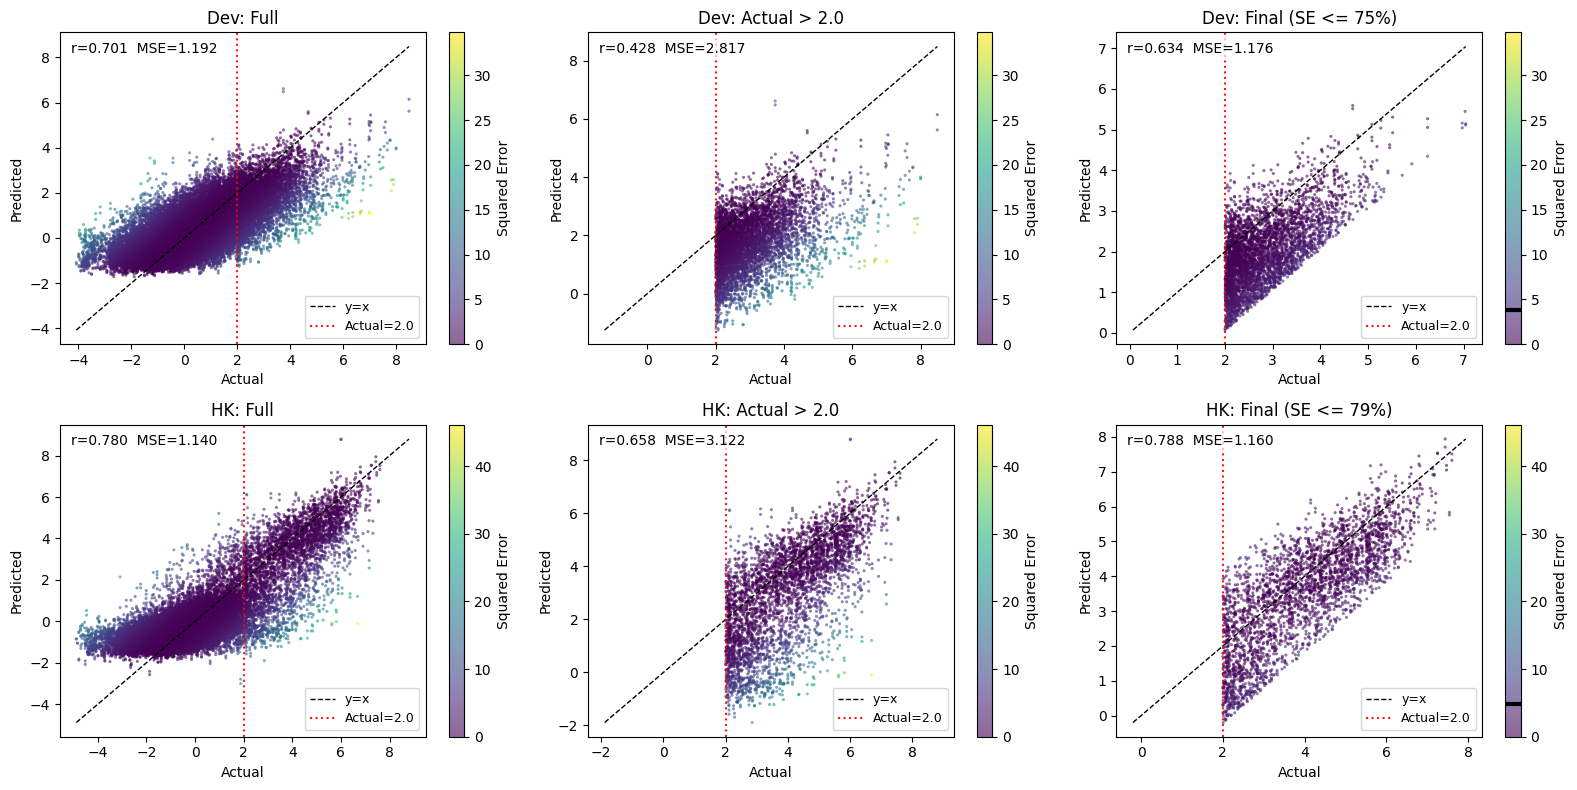

In [99]:
## Visualize the filtering process

# Figure and shared SE color scales per task
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
vmin_dev, vmax_dev = float(np.nanmin(se_dev)), float(np.nanmax(se_dev))
vmin_hk,  vmax_hk  = float(np.nanmin(se_hk)),  float(np.nanmax(se_hk))

# Final masks using subset-specific SE cutoffs
mask_final_dev = mask_actual_dev & (se_dev <= se_cut_dev) if np.isfinite(se_cut_dev) else np.zeros_like(mask_actual_dev, dtype=bool)
mask_final_hk  = mask_actual_hk  & (se_hk  <= se_cut_hk ) if np.isfinite(se_cut_hk)  else np.zeros_like(mask_actual_hk,  dtype=bool)

def plot_scatter(ax, x, y, c, title, vmin, vmax):
    sc = ax.scatter(x, y, c=c, s=5, cmap='viridis', alpha=0.6, edgecolor='none', vmin=vmin, vmax=vmax)
    xymin = float(min(x.min(), y.min()))
    xymax = float(max(x.max(), y.max()))
    diag, = ax.plot([xymin, xymax], [xymin, xymax], 'k--', lw=1, label='y=x')
    thr_line = ax.axvline(threshold, color='red', linestyle=':', linewidth=1.5, alpha=0.9, label='Actual=2.0')
    ax.set_title(title)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    # Annotate r and MSE
    if x.size >= 2:
        r = float(stats.pearsonr(y, x)[0]) if np.std(x) > 1e-12 and np.std(y) > 1e-12 else np.nan
    else:
        r = np.nan
    mse = float(np.mean((y - x)**2)) if x.size >= 1 else np.nan
    ax.text(0.03, 0.97, f"r={r:.3f}  MSE={mse:.3f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0))
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Squared Error')
    # Legend for lines
    ax.legend(loc='lower right', fontsize=9)
    return sc

print(f"Data has been filtered by actual values > 2.0 & SE <= {se_cut_dev:.3f} ({p_rec_dev_mse}%) for Dev & {se_cut_hk:.3f} ({p_rec_hk_mse}%) for HK.")
print(f"The SE cutoffs were made to remove the added variance at high activity levels. The logic recommends a SE cutoff that is closest to the full baseline performance.")
print(f"The half-full baseline performance could also be used as a cutoff, but this is not recommended as it is not as strict.")

# Dev panels
plot_scatter(axes[0, 0], y_true[:, 0], y_pred[:, 0], se_dev, 'Dev: Full', vmin_dev, vmax_dev)
plot_scatter(axes[0, 1], y_true[mask_actual_dev, 0], y_pred[mask_actual_dev, 0], se_dev[mask_actual_dev], 'Dev: Actual > 2.0', vmin_dev, vmax_dev)
sc_dev_final = plot_scatter(axes[0, 2], y_true[mask_final_dev, 0], y_pred[mask_final_dev, 0], se_dev[mask_final_dev], f'Dev: Final (SE <= {p_rec_dev_mse}%)', vmin_dev, vmax_dev)
# Mark 99th percentile on colorbar for Dev final (use same scale)
if mask_final_dev.any():
    cb_ax = axes[0, 2].collections[0].colorbar.ax
    cb_ax.axhline(se_cut_dev, color='black', linestyle='-', linewidth=3)

# HK panels
plot_scatter(axes[1, 0], y_true[:, 1], y_pred[:, 1], se_hk, 'HK: Full', vmin_hk, vmax_hk)
plot_scatter(axes[1, 1], y_true[mask_actual_hk, 1], y_pred[mask_actual_hk, 1], se_hk[mask_actual_hk], 'HK: Actual > 2.0', vmin_hk, vmax_hk)
sc_hk_final = plot_scatter(axes[1, 2], y_true[mask_final_hk, 1], y_pred[mask_final_hk, 1], se_hk[mask_final_hk], f'HK: Final (SE <= {p_rec_hk_mse}%)', vmin_hk, vmax_hk)
if mask_final_hk.any():
    cb_ax_h = axes[1, 2].collections[0].colorbar.ax
    cb_ax_h.axhline(se_cut_hk, color='black', linestyle='-', linewidth=3)

plt.tight_layout()